In [1]:
matchings_path = "./data/employee.json"
answers_path = "employee_ans.json"

In [2]:
from fact import FactSet
import numpy as np
import json

with open(matchings_path, "r") as f:
    content = json.load(f)

In [3]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [4]:
def process(content):
    import numpy as np
    c_set = content["correspondence_set"]
    # chatgpt 的tokens 的num list
    len_list = [len(encoding.encode(i[0][1]+i[1][1])) for i in c_set]
    matchings = content["matchings"]
    Views = []
    for match in matchings:
        view = []
        for c in c_set:
            if c in match:
                view.append(1)
            else:
                view.append(0)
        Views.append(view)
    return np.array(Views), np.array(content["prob_all"]), np.array(len_list)

In [5]:
facts, prob, len_list = process(content)
ex_fact = FactSet(facts=facts, prior_p=prob, ground_true=2, len_list=len_list)
cost_fact = FactSet(facts=facts, prior_p=prob, ground_true=2, len_list=len_list)
brute_fact = FactSet(facts=facts, prior_p=prob, ground_true=2, len_list=len_list)

In [6]:
from query import GreedyQuerySelector
 # 对应fact1, 3是0.8, 0.
query_selector = GreedyQuerySelector()
# selection_idxes, sub_facts, h = query_selector.select(ex_fact, 2, accuracy, cost_func=2)
cost_query_selector = GreedyQuerySelector()

In [7]:
import json
with open(answers_path, "r") as f:
    ans_list = json.load(f)

In [8]:
## params
# correspondence num
c_len = ex_fact.num_fact()

#LLM 预测准确率
p_w = 0.8
# 计算p(A_T) 和 P(A_T|v) 需要的LLM array:acc 
acc = np.array([[p_w for i in range(c_len)]])

# 每个token 一个
budget = 300 # 单位为 price of one token  
turns = 20
# k-selection 的参数
k = 4
##########################################

In [9]:
import numpy as np

approx_h_list=[ex_fact.compute_entropy()]
cost_h_list=[cost_fact.compute_entropy()]

have_cost_list = []
no_cost_list = []
have_cost_sum = 0
no_cost_sum = 0

while turns>0:
    selection_idxes, sub_facts, h = query_selector.select(ex_fact, k, acc, cost_func=1)
    
    # for ix in selection_idxes:
    #     cost_sum += ex_fact.len_list()[ix]
    #     ans=[1 if ans_list[ix]=="yes" else 0]
    #     p_a, p_a_v = ex_fact.compute_ans_p(ans, [ix], acc)
    #     sum_p = []
    #     for idx,i in enumerate(ex_fact.get_prior_p()):
    #         p_post = i*p_a_v[idx]/p_a
    #         sum_p.append(p_post)
    #     ex_fact.set_prior_p(np.array(sum_p))
    ans = [1 if ans_list[ix_r]=="yes" else 0 for ix_r in selection_idxes]
    p_a,p_a_v = ex_fact.compute_ans_p(ans, selection_idxes, acc)
    
    for ix_nc in selection_idxes.tolist():
        no_cost_sum += ex_fact.len_list()[ix_nc]
    no_cost_list.append(no_cost_sum)
    
    sum_p = []
    for idx,i in enumerate(ex_fact.get_prior_p()):
        p_post = i*p_a_v[idx]/p_a
        sum_p.append(p_post)
    ex_fact.set_prior_p(np.array(sum_p))
    approx_h_list.append(ex_fact.compute_entropy())
    
    cost_selection_idxes, sub_facts2, _ =cost_query_selector.select(cost_fact, k, acc, cost_func=2)
    ans_cost = [1 if ans_list[ix_cost]=="yes" else 0 for ix_cost in cost_selection_idxes]
    p_a_cost, p_a_v_cost = cost_fact.compute_ans_p(ans_cost, cost_selection_idxes, acc)
    
    for ix_c in cost_selection_idxes.tolist():
        have_cost_sum += cost_fact.len_list()[ix_c]
    have_cost_list.append(have_cost_sum)
    
    sum_p_cost = []
    for idx,i in enumerate(cost_fact.get_prior_p()):
        p_post_cost = i*p_a_v_cost[idx]/p_a_cost
        sum_p_cost.append(p_post_cost)
    cost_fact.set_prior_p(np.array(sum_p_cost))
    cost_h_list.append(cost_fact.compute_entropy())
    
    turns -=1

In [10]:
def per_c(uncertainty_l, cost_l):
    change_approx_l = [(uncertainty_l[0] - a1)/w for a1, w in zip(uncertainty_l[1:], cost_l)]
    return change_approx_l,  [(uncertainty_l[0] - a1) for a1 in uncertainty_l[1:]]

In [11]:
len(cost_h_list),len(have_cost_list)

(21, 20)

In [12]:
cost_per, cost_change = per_c(cost_h_list, have_cost_list)

In [13]:
no_cost_per, no_cost_change = per_c(approx_h_list, no_cost_list)

In [14]:
cost_per

[0.04532932574557166,
 0.05520226835259768,
 0.05111553557526485,
 0.04511592535609571,
 0.042788832100869714,
 0.04155786719211699,
 0.045479237975595804,
 0.04788722430794006,
 0.040233268263444276,
 0.03748721141768742,
 0.033183481637302496,
 0.03134183796428491,
 0.030528473131928788,
 0.027639115791695746,
 0.02653331085377776,
 0.02562239902865912,
 0.02546772212647101,
 0.022748696543239105,
 0.021836405872063896,
 0.02189144179362468]

In [15]:
no_cost_per

[0.053631772137454486,
 0.06024732690185116,
 0.05405895518374023,
 0.04313446979516318,
 0.03629069075536721,
 0.031135251955818025,
 0.035257496506405736,
 0.03715305821354436,
 0.034679040775340765,
 0.03113626806525395,
 0.030386173050074603,
 0.02904462359568876,
 0.028288407620296708,
 0.0261066712168072,
 0.025147488821375037,
 0.023863940276080714,
 0.021884472574374488,
 0.0213871286371774,
 0.02058445302428662,
 0.01874678379227074]

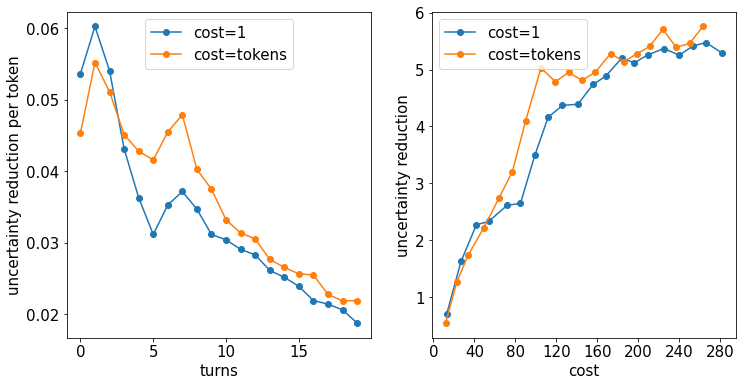

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(num=1,figsize=(12,6))
plt.rc('font', size=15)
ax=fig.add_subplot(1,2,1)

start = 0
end = max(no_cost_list[-1], have_cost_list[-1])
xs2 = np.arange(start, end, (end-start)//7)
xs = np.arange(20)

ax.set_xlabel("turns", fontsize=15)#添加x轴坐标标签，后面看来没必要会删除它，这里只是为了演示一下。
ax.set_ylabel("uncertainty reduction per token",fontsize=15)
ax.plot(xs, np.array(no_cost_per), linestyle='-', marker="o", label="cost=1")
ax.plot(xs, np.array(cost_per), linestyle='-', marker='o', label="cost=tokens")
ax.set_xticks(xs[::5])
ax.legend(loc="upper center")

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("cost", fontsize=15)
ax2.set_ylabel("uncertainty reduction", fontsize=15)
ax2.plot(no_cost_list, np.array(no_cost_change), linestyle='-', marker="o", label="cost=1")
ax2.plot(have_cost_list, np.array(cost_change), linestyle='-', marker='o', label="cost=tokens")
ax2.set_xticks(xs2)

ax2.legend(loc='upper left')    
plt.show()

In [17]:
fig.savefig("employee_cost.pdf")

In [18]:
with open(f"./output/p_w={p_w}_k={k}-cost.json","w") as f:
    save_d = {}
    save_d["no_cost"]=no_cost_per
    save_d["cost"] = cost_per